In [62]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader,Dataset
from PIL import Image

# inception_pet

In [86]:
class plot():
    def __init__(self, file="./result/inception_pet.txt", title='inceptionV3 with OxfordIIITPet dataset'):
        self.file = file
        self.title = title

        self.scores = np.loadtxt(self.file)
        self.scores_drop0, self.scores_0 = [],[]
        self.scores_drop0_idx, self.scores_0_idx = [], []

        for i in range(len(self.scores)):
            if self.scores[i] == 0:
                self.scores_0.append(self.scores[i])
                self.scores_0_idx.append(i)
            else:
                self.scores_drop0.append(self.scores[i])
                self.scores_drop0_idx.append(i)

        self.scores_drop0, self.scores_0 = np.array(self.scores_drop0), np.array(self.scores_0)
        self.scores_drop0_idx, self.scores_0_idx = np.array(self.scores_drop0_idx), np.array(self.scores_0_idx)
        # scores_0 = np.array([score for score in scores if score == 0])
        # scores = np.array([score for score in scores if score != 0]) #drop out values of 0 
        self.mean = np.mean(self.scores_drop0)
        self.std = np.std(self.scores_drop0)

    def plot_graph(self):
        plt.hist(self.scores_drop0, bins=30, color='c', edgecolor='black', alpha=0.7)
        plt.axvline(self.mean, color='r', linestyle='dashed', linewidth=1, label='Mean')
        # plt.axvline(mean_baseline + std_baseline, color='b', linestyle='dashed', linewidth=1, label='Mean + 1SD')
        # plt.axvline(mean_baseline - std_baseline, color='b', linestyle='dashed', linewidth=1, label='Mean - 1SD')
        plt.title(self.title)
        plt.xlabel('Rarity Score')
        plt.ylabel('Frequency')
        plt.legend(loc='upper right')
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

    def plot_table(self):
        #summary table
        df = pd.read_csv(self.file,names=["rarity score"])
        print(df.describe()) # table with 0 scores
        print(df[df["rarity score"]!=0].describe()) # table without 0 scores

    def display_image(self, dataset):
        sorted_scores_idx = np.argsort(self.scores_drop0)
        sorted_scores = self.scores_drop0[sorted_scores_idx]
        sorted_indices = self.scores_drop0_idx[sorted_scores_idx]
        
        middle_idx = len(sorted_scores) // 2
        # median_score = sorted_scores[middle_idx]
        # median_original_idx = sorted_indices[middle_idx]
        
        min_idx = self.scores_drop0_idx[self.scores_drop0.argmin()]
        max_idx = self.scores_drop0_idx[self.scores_drop0.argmax()]
        # median_idx = self.scores_drop0_idx[np.argwhere(self.scores_drop0 == np.median(self.scores_drop0))[0][0]]
        median_idx = self.scores_drop0_idx[np.argsort(self.scores_drop0)[len(self.scores_drop0)//2]]
        
        print(f"Image {min_idx+1} with lowest score {self.scores[min_idx]} ")
        print(f"Image {max_idx+1} with highest score {self.scores[max_idx]} ")
        print(f"Image {median_idx+1} with median score {self.scores[median_idx]}")
        
        for i, idx in enumerate([min_idx, max_idx, median_idx]):
            image, label = dataset[idx]
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()

            plt.imshow(image)
            plt.title(f'{["lowest","highest","median"][i]} at image {idx+1}')
            plt.axis('off')
            plt.show()



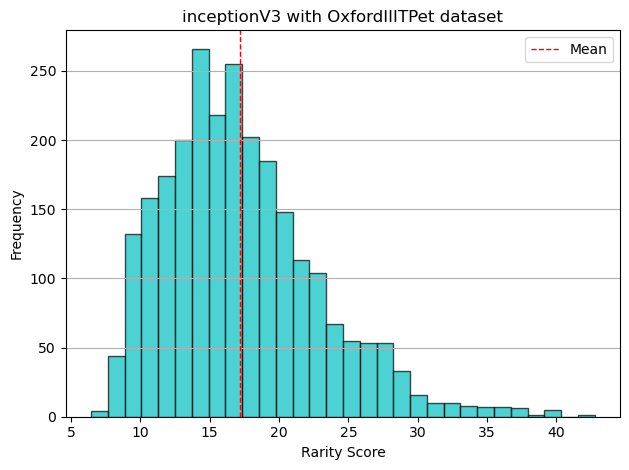

       rarity score
count   3669.000000
mean      11.893986
std        9.200498
min        0.000000
25%        0.000000
50%       13.668156
75%       18.172887
max       42.769030
       rarity score
count   2535.000000
mean      17.214609
std        5.558978
min        6.445198
25%       13.217317
50%       16.357587
75%       20.155100
max       42.769030
Image 2362 with lowest score 6.44519838113817 
Image 2025 with highest score 42.76902973989425 
Image 3637 with median score 16.357587190601485


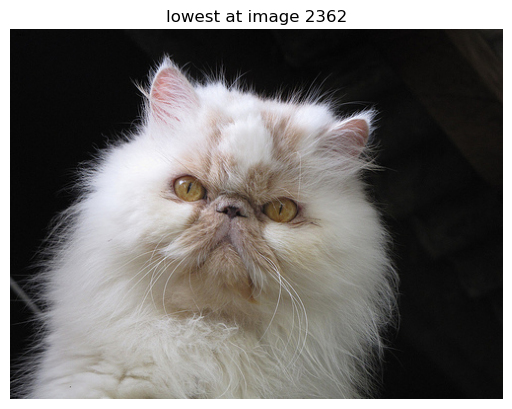

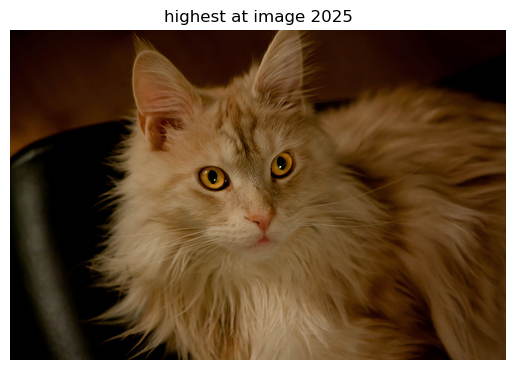

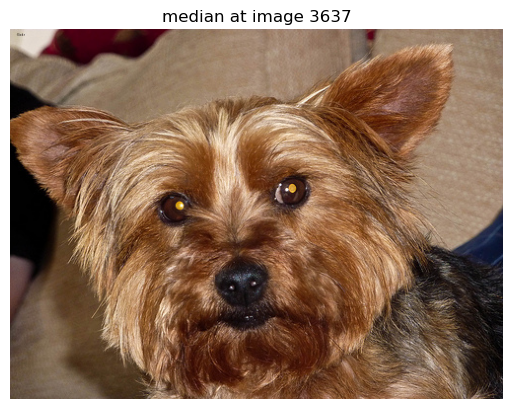

In [87]:
transform = transforms.Compose([
    # transforms.Resize((299, 299)),
    transforms.ToTensor()
])
test_pet_dataset = datasets.OxfordIIITPet(root="./oxford_pet_data/", split="test", download=False, transform=transform)

inception_pet = plot(file="./result/inception_pet.txt", title='inceptionV3 with OxfordIIITPet dataset')
inception_pet.plot_graph()
inception_pet.plot_table()
inception_pet.display_image(test_pet_dataset)



# inception widerface

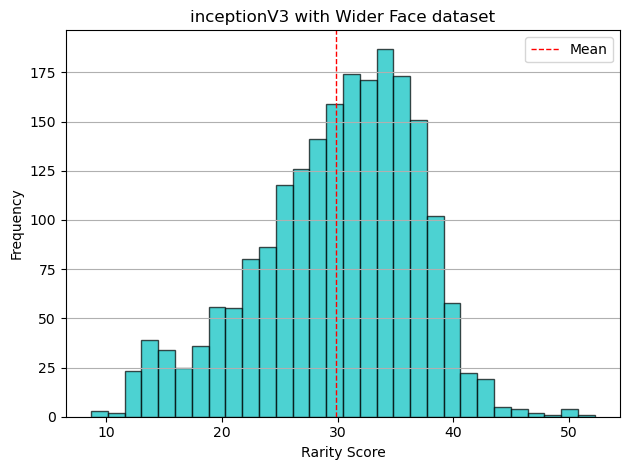

       rarity score
count   3226.000000
mean      19.055592
std       15.409641
min        0.000000
25%        0.000000
50%       24.732322
75%       32.558191
max       52.223014
       rarity score
count   2057.000000
mean      29.884948
std        6.976972
min        8.676028
25%       25.605035
50%       30.786917
75%       35.040227
max       52.223014
Image 2956 with lowest score 8.676028017665114 
Image 509 with highest score 52.223013693668825 
Image 678 with median score 30.786917421709745


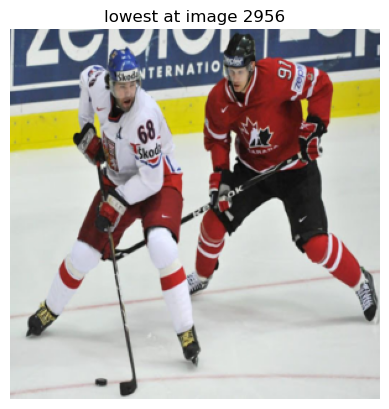

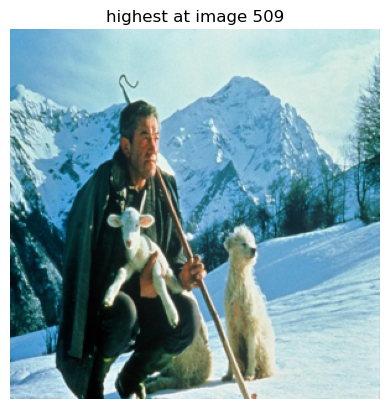

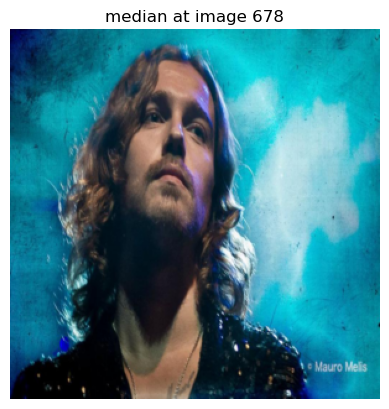

In [88]:
class WiderFaceDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.annotations = self.load_annotations(annotation_file)
        self.images = [annotation['image'] for annotation in self.annotations]

    def load_annotations(self, annotation_file):
        annotations = []
        with open(annotation_file, 'r') as file:
            lines = file.readlines()
            i = 0
            while i < len(lines):
                # read the image filename
                image_path = lines[i].strip()
                i += 1

                # the number of faces
                num_faces = int(lines[i].strip())
                i += 1  # Move to the first bounding box line or skip if num_faces is 0

                # if no faces, skip this image
                if num_faces == 0:
                    i += 1
                    continue

                boxes = []
                for _ in range(num_faces):
                    box_info = lines[i].strip().split()
                    # Extract the first four values (x, y, width, height)
                    x, y, w, h = [int(box_info[k]) for k in range(4)]
                    boxes.append([x, y, x + w, y + h])
                    i += 1

                annotations.append({'image': image_path, 'boxes': boxes})

        return annotations



    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.annotations[index]['image'])
        img = Image.open(img_path)

        original_size = img.size

        # corresponding bounding boxes
        bboxes = self.annotations[index]['boxes']

        # apply image transformations()
        if self.transform:
            img = self.transform(img)

        # scale factors
        scale_x = 299 / original_size[0]
        scale_y = 299 / original_size[1]

        # scale the bounding boxes
        scaled_bboxes = []
        for box in bboxes:
            x1, y1, x2, y2 = box
            scaled_bboxes.append([x1 * scale_x, y1 * scale_y, x2 * scale_x, y2 * scale_y])

        # convert scaled bounding boxes(annotations) to a tensor
        scaled_bboxes = torch.tensor(scaled_bboxes, dtype=torch.float32)

        return img, scaled_bboxes

transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

test_wider_dataset = WiderFaceDataset(image_dir='./widerface_data/widerface/WIDER_val/images/', 
                                 annotation_file='./widerface_data/widerface/wider_face_split/wider_face_val_bbx_gt.txt', 
                                 transform=transform_inception)


inception_widerface = plot(file="./result/inception_widerface.txt", title='inceptionV3 with Wider Face dataset')
inception_widerface.plot_graph()
inception_widerface.plot_table()
inception_widerface.display_image(test_wider_dataset)

# resnet pet

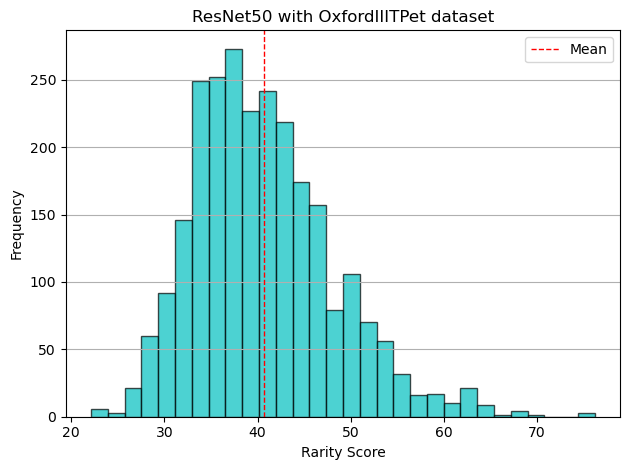

       rarity score
count   3669.000000
mean      28.203564
std       19.750564
min        0.000000
25%        0.000000
50%       35.760938
75%       42.357158
max       76.174941
       rarity score
count   2546.000000
mean      40.643706
std        7.510020
min       22.139784
25%       35.161113
50%       39.679748
75%       44.967339
max       76.174941
Image 2488 with lowest score 22.139783568989483 
Image 591 with highest score 76.17494139286578 
Image 2518 with median score 39.68830657430972


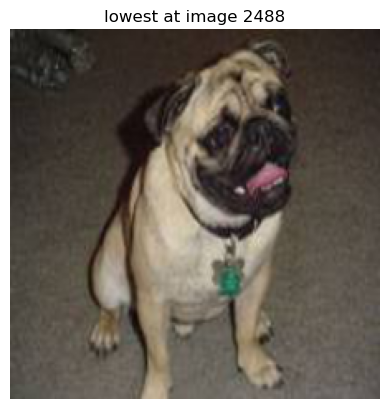

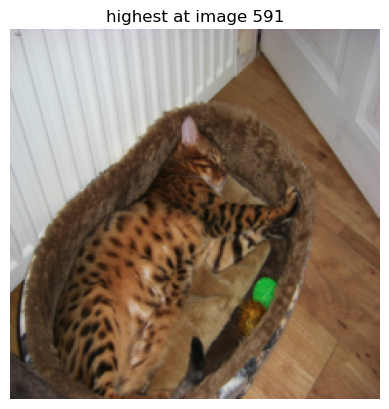

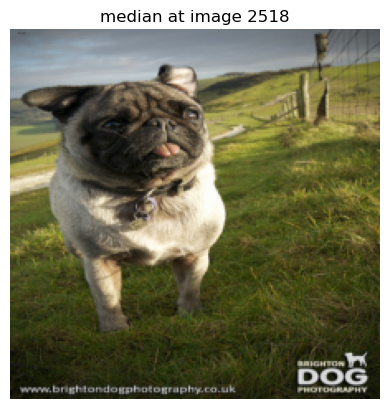

In [93]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_pet_dataset = datasets.OxfordIIITPet(root="./oxford_pet_data/", split="test", download=False, transform=transform_resnet)


resnet_pet = plot(file="./result/resnet_pet.txt", title='ResNet50 with OxfordIIITPet dataset')
resnet_pet.plot_graph()
resnet_pet.plot_table()
resnet_pet.display_image(test_pet_dataset)

# ResNet50 widerface

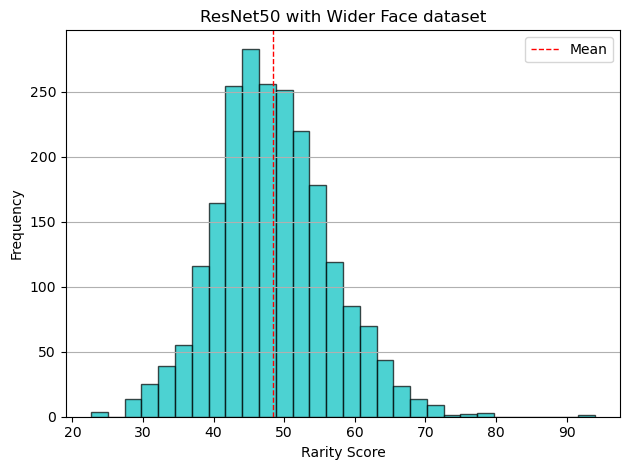

       rarity score
count   3226.000000
mean      33.500818
std       23.365424
min        0.000000
25%        0.000000
50%       43.590594
75%       50.823507
max       93.994181
       rarity score
count   2231.000000
mean      48.441792
std        8.089767
min       22.635001
25%       43.068523
50%       47.819330
75%       53.475542
max       93.994181
Image 339 with lowest score 22.635001495183605 
Image 390 with highest score 93.99418098737307 
Image 795 with median score 47.81932969951639


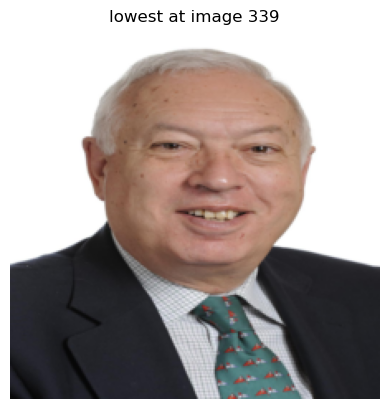

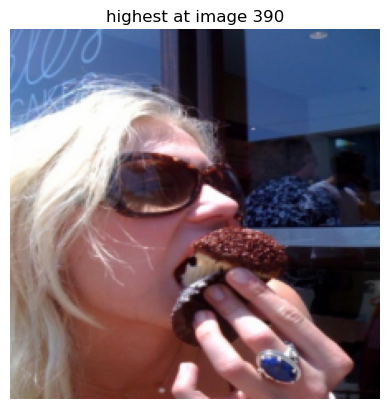

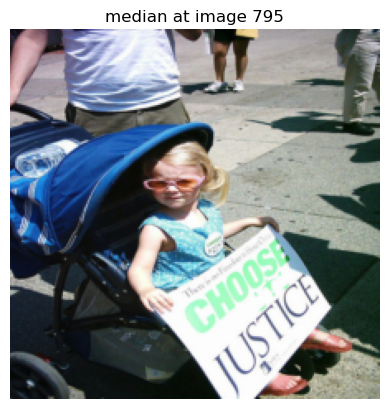

In [94]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_wider_dataset = WiderFaceDataset(image_dir='./widerface_data/widerface/WIDER_val/images/', 
                                 annotation_file='./widerface_data/widerface/wider_face_split/wider_face_val_bbx_gt.txt', 
                                 transform=transform_resnet)

resnet_widerface = plot(file="./result/resnet_widerface.txt", title='ResNet50 with Wider Face dataset')
resnet_widerface.plot_graph()
resnet_widerface.plot_table()
resnet_widerface.display_image(test_wider_dataset)

# inceptionV3 celebA (images in result/inception_celeba)

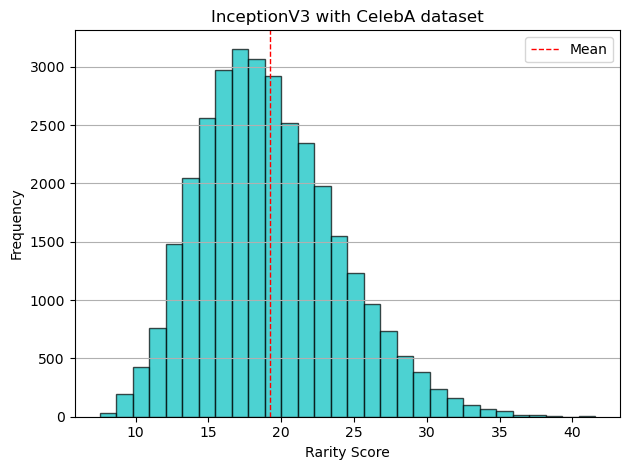

       rarity score
count  48831.000000
mean      12.788966
std        9.861085
min        0.000000
25%        0.000000
50%       15.705326
75%       20.298518
max       41.566554
       rarity score
count  32525.000000
mean      19.200554
std        4.783641
min        7.520943
25%       15.712861
50%       18.694603
75%       22.234097
max       41.566554


In [96]:
transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

inception_celeba = plot(file="./result/inception_celeba.txt", title='InceptionV3 with CelebA dataset')
inception_celeba.plot_graph()
inception_celeba.plot_table()


# ResNet 50 celebA

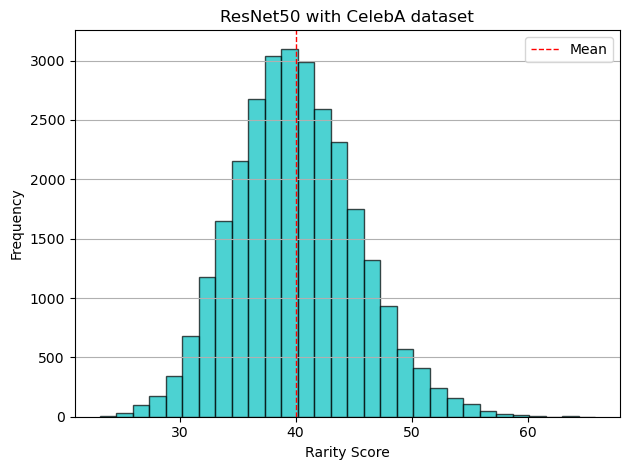

       rarity score
count  48831.000000
mean      23.461663
std       20.139591
min        0.000000
25%        0.000000
50%       34.525438
75%       40.784360
max       65.811549
       rarity score
count  28605.000000
mean      40.050916
std        5.288543
min       23.110709
25%       36.406899
50%       39.819196
75%       43.479177
max       65.811549


In [97]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
resnet_celeba = plot(file="./result/resnet_celeba.txt", title='ResNet50 with CelebA dataset')
resnet_celeba.plot_graph()
resnet_celeba.plot_table()